### Dependencies setup

In [1]:
!pip install qiskit --quiet
!pip install qiskit-ibm-runtime --quiet
!pip install qiskit[visualization] -quiet
!pip install networkx --quiet
!pip install qiskit-optimization --quiet



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


### Construct graphs

In [2]:
import matplotlib.pyplot as plt

def draw_graph(graph, nodes_to_color):
    """
    Draw a graph with nodes colored red based on the list of nodes provided.

    Args:
    - graph: A NetworkX graph object.
    - nodes_to_color: A list of nodes to color red.

    Returns:
    - None
    """
    # Create an empty plot
    plt.figure(figsize=(8, 6))

    # Draw the graph
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=800, font_size=12)

    # Draw nodes to color red
    nx.draw_networkx_nodes(graph, pos, nodelist=nodes_to_color, node_color='red', node_size=800)

    # Show the plot
    plt.title("Graph with Nodes Colored Red")
    plt.show()


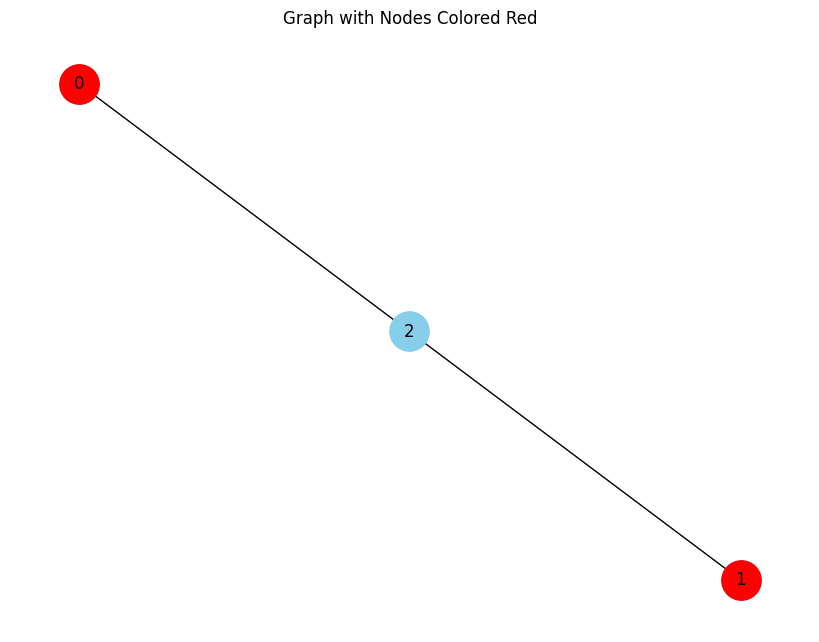

In [3]:
import networkx as nx

# Create an empty graph
G3 = nx.Graph()

G3.add_nodes_from(range(3))

# Add edges
G3.add_edges_from([(0, 2), (1, 2)])

# Visualize the graph
draw_graph(G3,[0,1])

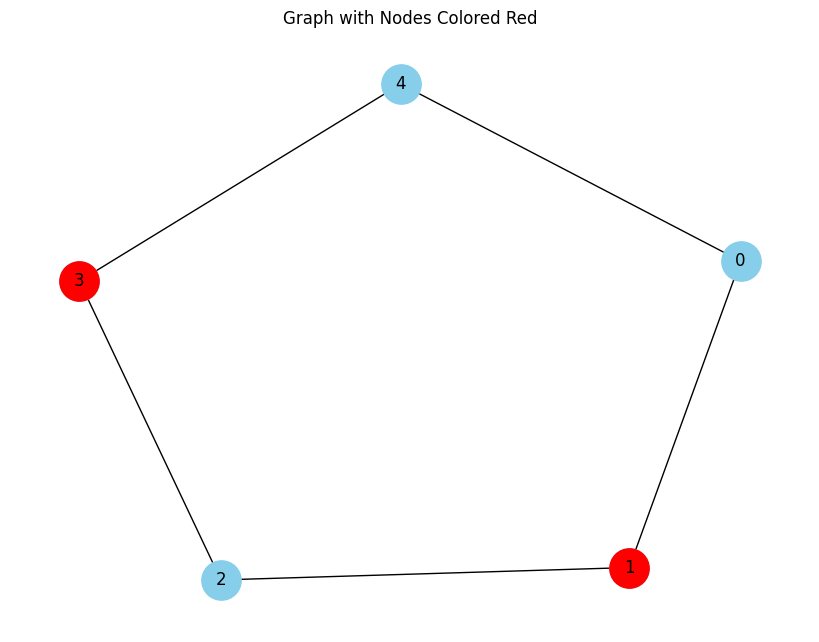

In [4]:
# Create an cyclic graph
G5 = nx.cycle_graph(5)

# Visualize the graph
draw_graph(G5,[1,3])

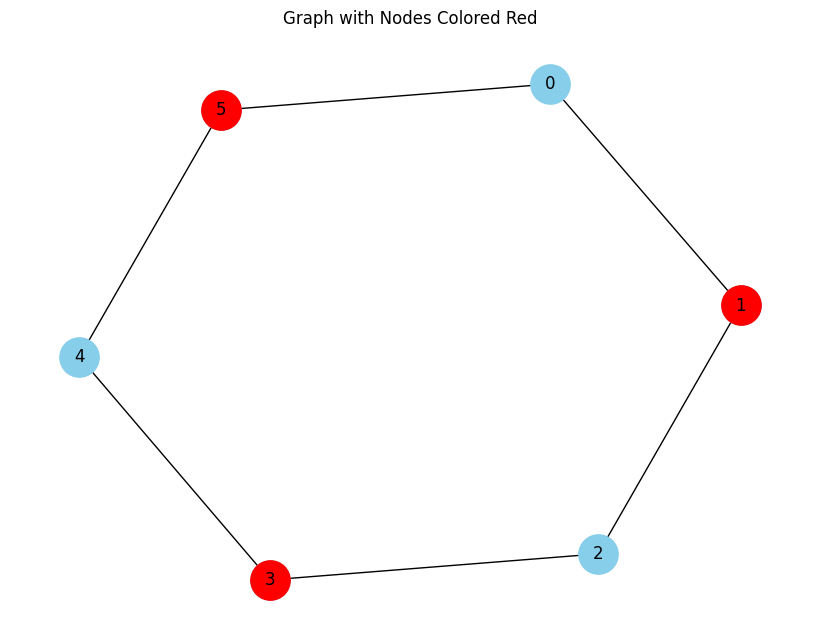

In [5]:
# Create an cyclic graph
G6 = nx.cycle_graph(6)

# Visualize the graph
draw_graph(G6,[1,3,5])

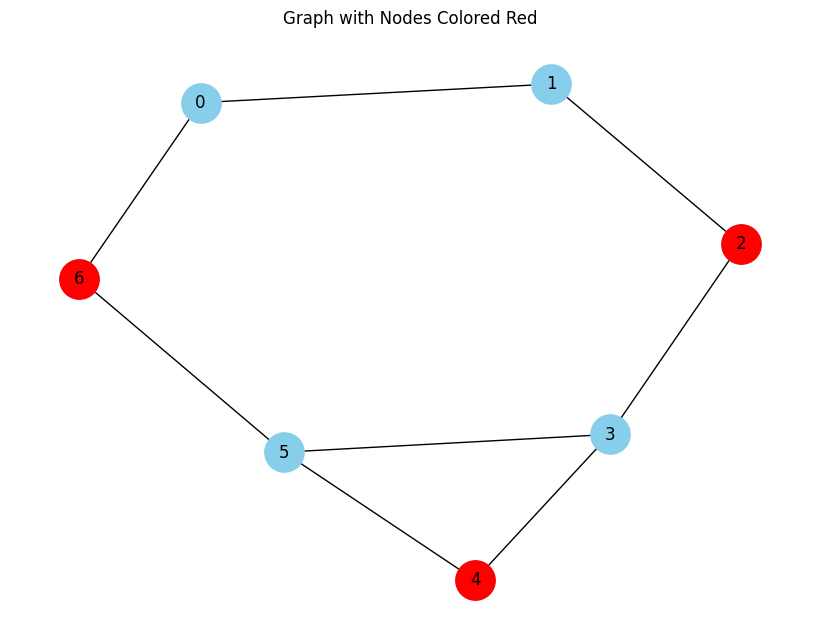

In [6]:
# Create an cyclic graph
G7 = nx.cycle_graph(7)
G7.add_edges_from([(3,5)])

# Visualize the graph
draw_graph(G7,[2,4,6])

### QAOA

In [7]:
from qiskit_optimization.problems import QuadraticProgram

def maximal_independent_set_qubo(graph):
    """
    Formulate the QUBO for the Maximal Independent Set problem.

    Args:
    - graph: A NetworkX graph object.

    Returns:
    - A Qiskit QuadraticProgram object representing the QUBO.
    """
    qp = QuadraticProgram()

    # Define binary variables for each node
    for node in graph.nodes():
        qp.binary_var(name=f'x_{node}')

    # Add objective function: maximize the number of nodes in the independent set
    linear = { f'x_{node}': -1 for node in graph.nodes()}
    quadratic = { (f'x_{i}',f'x_{j}') : 2 for i,j in graph.edges()}
    qp.minimize(linear = linear, quadratic= quadratic)

    return qp

In [8]:
test = maximal_independent_set_qubo(G3)
print(test.prettyprint())

Problem name: 

Minimize
  2*x_0*x_2 + 2*x_1*x_2 - x_0 - x_1 - x_2

Subject to
  No constraints

  Binary variables (3)
    x_0 x_1 x_2



### Solve using gate based QAOA i.e. VQE

In [9]:
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import SPSA
from qiskit.primitives import Sampler
from qiskit_optimization.applications.optimization_application import OptimizationApplication


def callback_vqe(eval_count, parameters, eval_value, std):
    print(f"count : {eval_count}, evaluated value : {eval_value}")

def solve(qubo):
  qubitOp, offset = qubo.to_ising()

  optimizer = SPSA(maxiter=300)
  ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
  vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

  # run SamplingVQE
  result = vqe.compute_minimum_eigenvalue(qubitOp)

  # Post processing to get nodes
  sample = OptimizationApplication.sample_most_likely(result.eigenstate)
  nodes = [i for i,chosen in enumerate(sample) if chosen == 1]

  return nodes

In [10]:
def maximal_independent_set(graph):
  qubo = maximal_independent_set_qubo(graph)
  maximal_independent_nodes = solve(qubo)

  draw_graph(graph, maximal_independent_nodes)

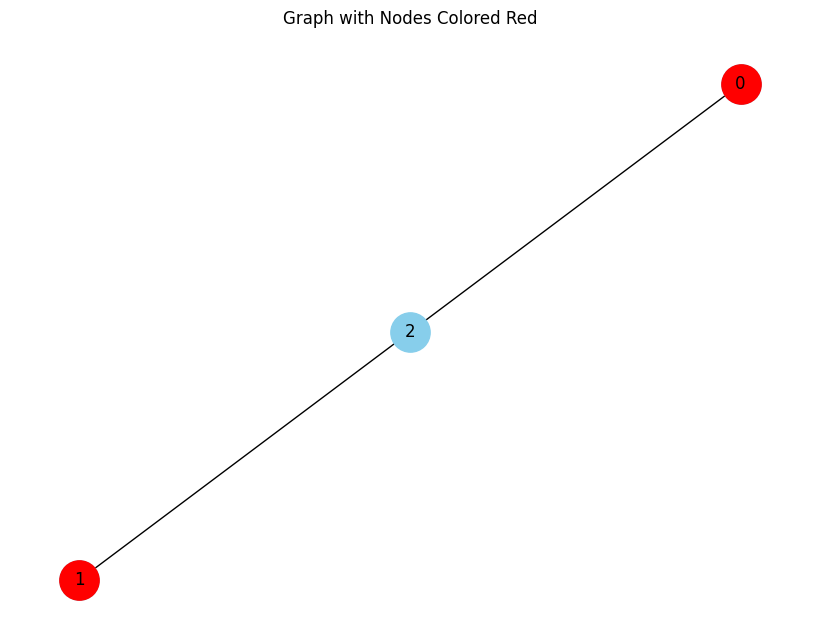

In [11]:
maximal_independent_set(G3)

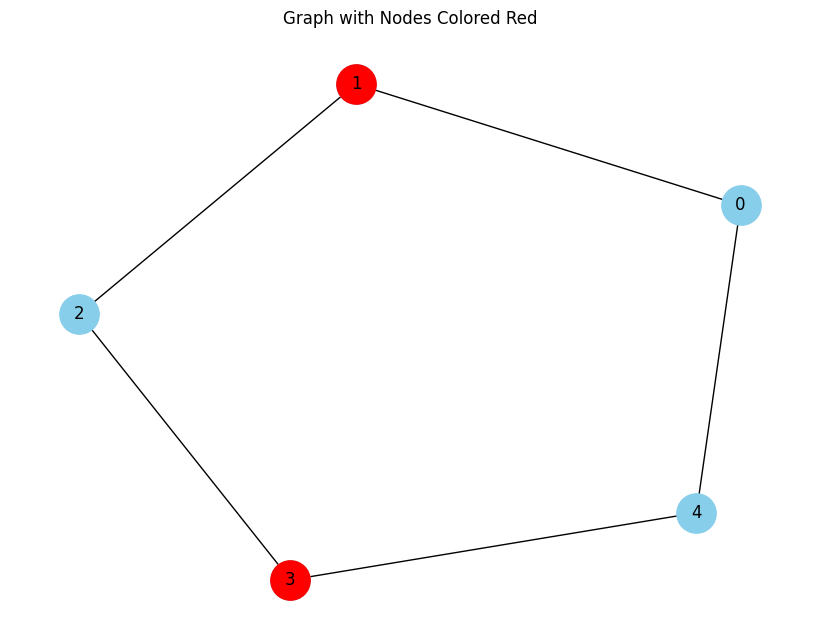

In [12]:
maximal_independent_set(G5)

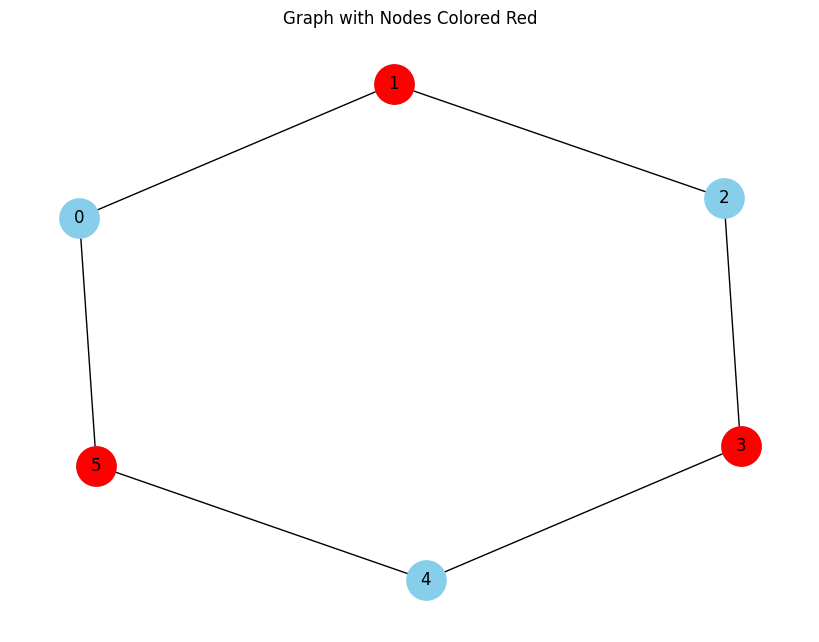

In [13]:
maximal_independent_set(G6)

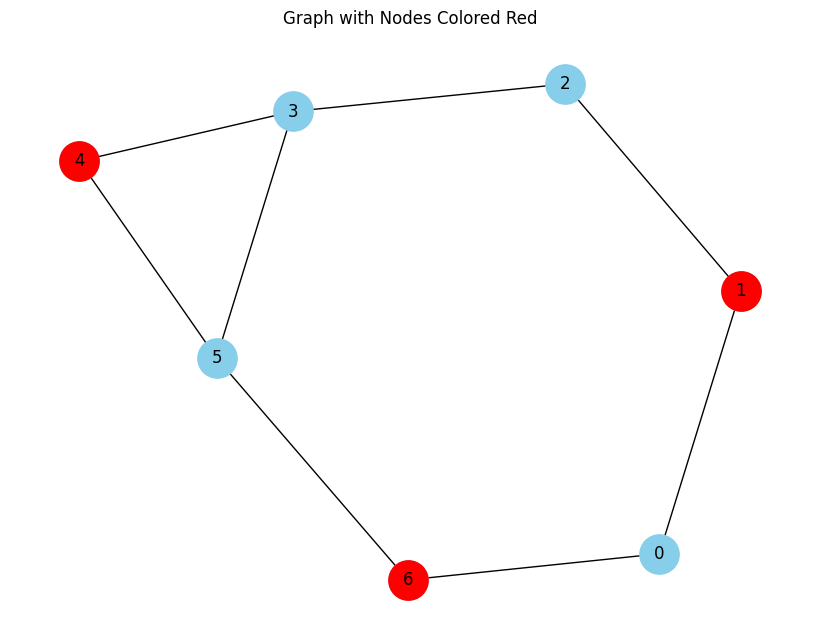

In [14]:
maximal_independent_set(G7)